# Lab 3: Alignment-based metrics in Machine Learning

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A lab session from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.metrics import dtw, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

# Data loading

**Question #1.** Using the [`CachedDatasets`](https://tslearn.readthedocs.io/en/stable/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets)
utility from ``tslearn``, load the "Trace" time series dataset.
What are the dimensions of an array storing a time series dataset?
Create a new dataset `X_subset` made of 50 random time series from classes indexed 1 to 3 (`y_train < 4`)
in the training set.

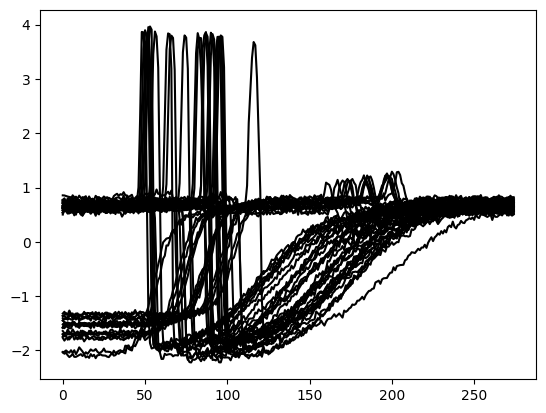

In [2]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

X_subset = X_train[y_train < 4]
np.random.shuffle(X_subset)
X_subset = X_subset[:50]

for ts in X_subset:
    plt.plot(ts[:, 0], color='k')

# $k$-means clustering

**Question #2.** Implement the Lloyd's algorithm for a $k$-means that would use soft-DTW as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iterations on `X_subset` (leave quantitative evaluation aside for now).

In [3]:
def kmeans_soft_dtw(X, gamma, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape

    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dists = []
            for j in range(k):
                dists.append(soft_dtw(X[i], barycenters[j], gamma=gamma))
            assign[i] = np.argmin(dists)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            barycenters[j] = softdtw_barycenter(X[assign == j], gamma=gamma)
    
    return assign, barycenters

assign, centroids = kmeans_soft_dtw(X_subset, gamma=.1, k=3, max_iter=3)

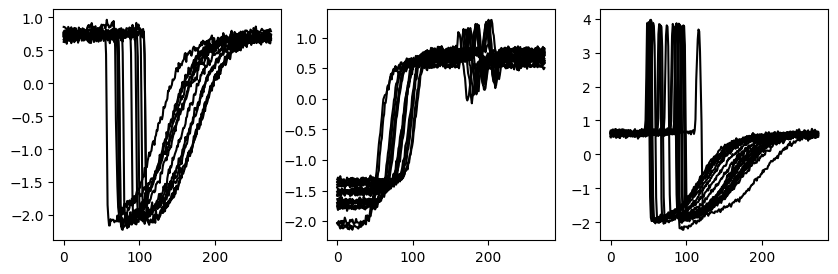

In [4]:
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for ts in X_subset[assign == i]:
        plt.plot(ts[:, 0], 'k')

**Question #3.** Implement the Lloyd's algorithm for a $k$-means that would use **DTW** as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iteration on `X_subset` (leave quantitative evaluation aside for now).

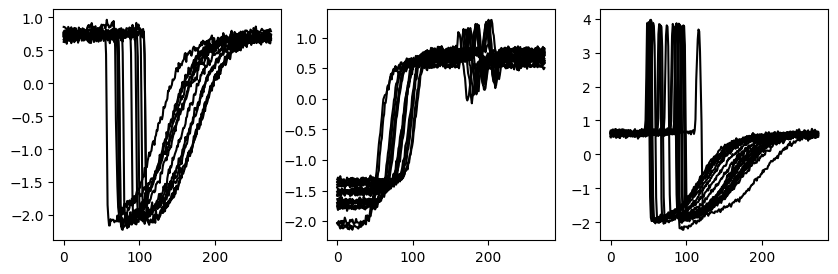

In [5]:
def kmeans_dtw(X, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape

    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dists = []
            for j in range(k):
                dists.append(dtw(X[i], barycenters[j]))
            assign[i] = np.argmin(dists)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            barycenters[j] = dtw_barycenter_averaging(X[assign == j])
    
    return assign, barycenters

assign, centroids = kmeans_dtw(X_subset, k=3, max_iter=3)
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for ts in X_subset[assign == i]:
        plt.plot(ts[:, 0], 'k')

**Question #4.** Implement a function that would assess the quality of a clustering in terms of 
intra-cluster inertia, computed using **DTW** as the base metric.
Your function should take a time series dataset, corresponding assignments and barycenters as inputs.

In [6]:
def dtw_cost(X, assign, barycenters):
    n_timeseries, n_timestamps, n_features = X.shape
    k = barycenters.shape[0]

    total_cost = 0.
    for j in range(k):
        for ts in X[assign == j]:
            total_cost += dtw(ts, barycenters[j]) ** 2
    
    return total_cost



**Question #5.** Compare your $k$-means implementations in terms of DTW inertia.
For a fair comparison, make sure that they are initialized similarly, by appropriately setting your
random number generator seeds.
What do you observe? Is that expected / Do you have an explanation for that?

In [7]:
np.random.seed(0)
assign, centroids = kmeans_dtw(X_subset, k=3, max_iter=3)
print("DTW kmeans:", dtw_cost(X_subset, assign, centroids))

np.random.seed(0)
assign, centroids = kmeans_soft_dtw(X_subset, k=3, gamma=.1, max_iter=3)
print("softDTW kmeans:", dtw_cost(X_subset, assign, centroids))

DTW kmeans: 113.16681135179171
softDTW kmeans: 107.59902426504895


# Multi-step ahead forecasting

In this section, your goal will be to implement a single-hidden-layer perceptron for time series forecasting.
Your network will be trained to minimize normalized soft-DTW[^1].

To do so, we will rely on a (very nice!) `torch`-compatible implementation of soft-DTW available in `tslearn`.

[^1]: Normalized soft-DTW (also coined soft-DTW divergence) between time series $\mathbf{x}$ and 
$\mathbf{x}^\prime$ is defined as: 
$$\text{soft-DTW}(\mathbf{x}, \mathbf{x}^\prime) - \frac{1}{2} \left( \text{soft-DTW}(\mathbf{x}, \mathbf{x}) + \text{soft-DTW}(\mathbf{x}^\prime, \mathbf{x}^\prime) \right)$$


**Question #6.** Define an MLP model that would allow training
a single-hidden-layer model using normalized soft-DTW as a criterion to be optimized.
Train your network for 200 epochs on a forecasting task that would consist, given the first 150 elements
of a time series, in predicting the next 125 ones.

In [8]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Reshape

from tslearn.metrics import SoftDTWLossPyTorch

model = Sequential([
    InputLayer(shape=(150, 1)),
    Reshape(target_shape=(150, )),

    Dense(units=256, activation="relu"),
    Dense(units=125),
    
    Reshape(target_shape=(125, 1))
])
model.compile(optimizer="adam", loss=SoftDTWLossPyTorch(gamma=.1, normalize=True))
model.fit(X_subset[:, :150], X_subset[:, 150:], epochs=100, batch_size=10)  # Here one needs to define what X and y are, obviously

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 78.5603  
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 26.7571
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.6546
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.4237
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4903
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9584
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3533
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4878
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1568
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7110
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3846
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2317 
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1467
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9693
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8625
Epoch 16/100
5

**Question #7.** Use the following code block to qualitatively assess quality of your 
network's predictions.
Do not hesitate to change the time series index to visualize the result for different time series.

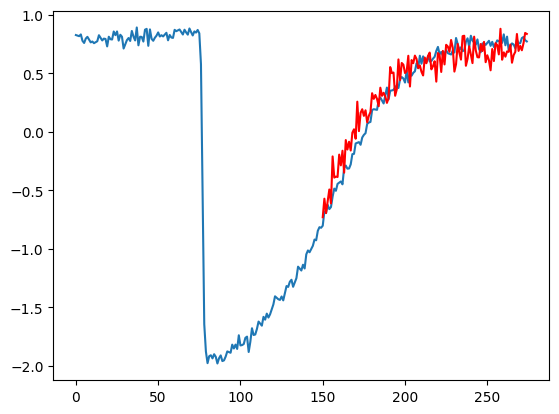

In [9]:
import matplotlib.pyplot as plt

ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

# Shapelet models

Shapelet models are time series classifiers that rely on the presence/absence of local shapes in 
time series to make predictions.
These models will be presented in more details later in the course, since they can be seen as a variant of 
shallow convolutional models for time series.

In the following, you will train such models (using their 
[`tslearn` implementation](https://tslearn.readthedocs.io/en/stable/gen_modules/shapelets/tslearn.shapelets.LearningShapelets.html#tslearn.shapelets.LearningShapelets)) 
and visualize their learned decision boundaries.
For the sake of visualization, models made of only 2 local shapes will be learned, and the following 
function will be used to visualize them:

In [10]:
from matplotlib import cm

def visualize_shapelet_model_2_shapelets(model, X, y):
    distances = model.transform(X)

    plt.figure()
    viridis = cm.get_cmap('viridis', 4)
    # Create a scatter plot of the 2D distances for the time series of each class.
    for i, yi in enumerate(np.unique(y)):
        plt.scatter(distances[y == yi][:, 0],
                    distances[y == yi][:, 1],
                    color=viridis(i / 3),
                    edgecolors='k',
                    label='Class {}'.format(yi))

    # Create a meshgrid of the decision boundaries
    xmin = np.min(distances[:, 0]) - 0.1
    xmax = np.max(distances[:, 0]) + 0.1
    ymin = np.min(distances[:, 1]) - 0.1
    ymax = np.max(distances[:, 1]) + 0.1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) / 200), 
                         np.arange(ymin, ymax, (ymax - ymin) / 200))
    
    weights, biases = model.get_weights('classification')
    Z = []
    for x, y in np.c_[xx.ravel(), yy.ravel()]:
        Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                            for i in range(4)]))
    Z = np.array(Z).reshape(xx.shape)
    plt.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

    plt.legend()
    plt.xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
    plt.ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.title('Distance transformed time series')
    plt.show()

Let us start with a first attempt.
The following code snippet defines a model made of 2 shapelets (=local shapes to be learnt) and train
them (as well as the corresponding linear decision boundaries) for 500 epochs:

In [11]:
from tslearn.shapelets import LearningShapelets

shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=False,
    random_state=42
)
shp_clf.fit(X_train, y_train)

ModuleNotFoundError: No module named 'tensorflow.keras'

**Question #8.** Visualize the obtained decision boundaries. 
Would you expect this model to be a decent classifier?

In [ ]:
visualize_shapelet_model_2_shapelets(shp_clf, X_test, y_test)

**Question #9.** Shapelet models usually benefit from scaling of the input time series 
(yet this is, of course, very dataset-specific).
See if this helps in our case.

In [ ]:
shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=True,
    random_state=42
)
shp_clf.fit(X_train, y_train)
visualize_shapelet_model_2_shapelets(shp_clf, X_test, y_test)

In [ ]:
visualize_shapelet_model_2_shapelets(shp_clf, X_train, y_train)

**Question #10.** By default, the `tslearn` implementation uses SGD as an optimizer.
See if using `"adam"` helps in our case.

In [ ]:
shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=True,
    optimizer="adam",
    random_state=42
)
shp_clf.fit(X_train, y_train)
visualize_shapelet_model_2_shapelets(shp_clf, X_test, y_test)

**Question #11.** Set the learning rate of the Adam optimizer to 1e-2 
(you will need to import the `Adam` class from `keras` as follows) and see if this improves the learning.

In [ ]:
from keras.optimizers import Adam

shp_clf = LearningShapelets(
    n_shapelets_per_size={20: 2},  # 2 shapelets of length 20
    max_iter=500,
    verbose=0,                     # Do not print information on the evolution of the loss
    scale=True,
    optimizer=Adam(learning_rate=1e-2),
    random_state=42
)
shp_clf.fit(X_train, y_train)
visualize_shapelet_model_2_shapelets(shp_clf, X_test, y_test)